In [ ]:
#virtual env activate한 뒤에 pip install scikit-image 

### Semantic Segmentation using FCN
이번 실습에서는 **VGG-16** network 구조에 **FCN**을 적용하여 _Semantic Segmentation_을 구현해보도록 한다.

In [1]:
%matplotlib inline

import os
import sys
import math
import numpy as np
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
import skimage.transform
from skimage import io
from numpy import ogrid, repeat, newaxis

sys.path.append(os.path.join(os.getcwd(), '..'))
from voc_loader import VOC_loader
import fcn_vgg

from loss import loss as get_loss
from utils import *

slim = tf.contrib.slim

#### Segmentation 결과 비교
아래 함수는 _original image_, _ground truth segmentation_, _predicted segmentation_을 순서대로 화면에 출력하는 코드이다.

In [2]:
def plot_result(img, gt_seg, pred_seg, palette):
    if pred_seg is None:
        f, (ax1, ax2) = plt.subplots(1, 2)
    else:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3)
        
    ax1.imshow(img.astype(np.uint8))
    ax2.imshow(gt_seg.astype(np.uint8))
    
    if pred_seg is not None:
        #np.place(pred_seg, pred_seg == 21, 255)
        tmp = Image.fromarray(pred_seg.astype(np.uint8), 'P')
        tmp.putpalette(palette)
        ax3.imshow(tmp)
    
    plt.show()

### Download PASCAL VOC 2007 dataset
**PASCAL VOC** dataset은 classification, detection, segmentation 3개의 성능 평가를 지원하는 dataset으로 이번 실습에서는 **VOC 2007** segmentation dataset을 사용한다. dataset 구성은 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor' 총 20개의 클래스로 이루어져 있다.

자세한 dataset 구성은 아래 documentation에 나와있다.

**Pascal VOC 2012**

http://host.robots.ox.ac.uk/pascal/VOC/voc2012/htmldoc/index.html


**Pascal VOC 2007**

Doc: http://pjreddie.com/media/files/VOC2007_doc.pdf

Download link: http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar

In [3]:
if not os.path.exists('VOCdevkit'):
    '''
    # PASCAL VOC 2012
    os.system('wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar')
    os.system('tar xvf VOCtrainval_11-May-2012.tar')
    '''
    # PASCAL VOC 2007
    os.system('wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar')
    os.system('tar xvf VOCtrainval_06-Nov-2007.tar')
    

### Download VGG-16 Network Model

In [4]:
data_dir = 'vgg_models'
data_url = 'http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz'
maybe_download_and_extract(data_url, data_dir, 'vgg_16.ckpt')

>> Downloading vgg_16_2016_08_28.tar.gz 4.8%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Downloading vgg_16_2016_08_28.tar.gz 11.4%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Downloading vgg_16_2016_08_28.tar.gz 17.9%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Downloading vgg_16_2016_08_28.tar.gz 24.5%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Downloading vgg_16_2016_08_28.tar.gz 30.4%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Downloading vgg_16_2016_08_28.tar.gz 36.4%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Downloading vgg_16_2016_08_28.tar.gz 42.5%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Downloading vgg_16_2016_08_28.tar.gz 48.8%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Downloading vgg_16_2016_08_28.tar.gz 55.6%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Downloading vgg_16_2016_08_28.tar.gz 62.6%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Downloading vgg_16_2016_08_28.tar.gz 75.0%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Downloading vgg_16_2016_08_28.tar.gz 82.6%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Downloading vgg_16_2016_08_28.tar.gz 97.0%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Load VOC 2007 Dataset
다운 받은 **PASCAL VOC 2007** dataset을 읽어온다. **VOCdevkit/VOC2007** 폴더를 살펴보면 Segmentation에 사용될 image name이 저장되어 있는 txt 파일이 **split_root**에 있고 원본 image는 **image_root**에 있으며 **segmap_root**는 각 이미지 별로 grount truth segmentation에 대한 정보를 가지고 있다. 추후 **segmap_root**의 정보를 가지고 segmentation이 얼마나 잘 되었는 지를 평가할 것이다.

FCN을 VGG network를 수정하여 구현할 것이므로 input image size는 224가 된다. _num_classes_는 **PASCAL VOC 2007** dataset의 20개의 클래스와 배경 픽셀, 그리고 image의 각 object의 경계선을 나타내는 (학습에 사용되지 않는 영역) void 픽셀을 포함하여 총 22개로 정의된다.

In [5]:
loader_params = {
    'num_classes': 22,
    'image_size': 224,
    # PASCAL VOC 2012
    #'split_root': 'VOCdevkit/VOC2012/ImageSets/Segmentation',
    #'image_root': 'VOCdevkit/VOC2012/JPEGImages',
    #'segmap_root': 'VOCdevkit/VOC2012/SegmentationClass',
    # PASCAL VOC 2007
    'split_root': 'VOCdevkit/VOC2007/ImageSets/Segmentation',
    'image_root': 'VOCdevkit/VOC2007/JPEGImages',
    'segmap_root': 'VOCdevkit/VOC2007/SegmentationClass',
}
loader = VOC_loader(loader_params)

# get information for VOC
class_names = loader.get_class_names()
num_classes = loader_params['num_classes']
img_size = loader_params['image_size']

### Check the dataset
dataset이 잘 load 되었는 지 확인하기 위해 5개의 images를 출력해보는 부분이다.

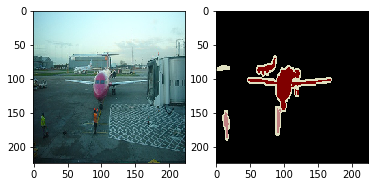

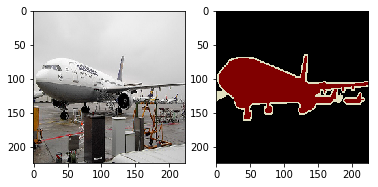

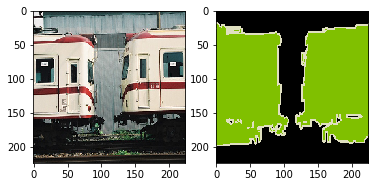

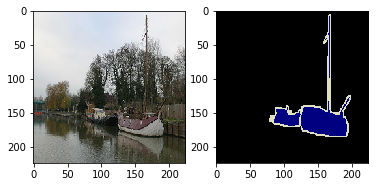

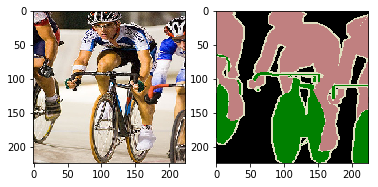

In [6]:
check_batchs = 5
batch = loader.get_batch(check_batchs)

for ii in range (check_batchs):
    plot_result(batch['images'][ii], batch['seg_maps'][ii], 
                None, None)

### Parameters
이전 실습과 마찬가지로 학습에 사용될 parameters를 정의한 부분이다.

In [7]:
initial_learning_rate = 0.0001 # initial learning rate for optimizer

batch_size = 4
num_epochs = 10

iteration_per_epoch = int(math.floor(loader.get_num_train_examples() / batch_size))
save_checkpoint_frequency = int(math.floor(iteration_per_epoch / 5))
print_frequency = 50

print("number of training data: %d" % loader.get_num_train_examples())
print("batch size: %d" % batch_size)
print("iterations per epoch: %d" % iteration_per_epoch)
print("number of epoch: %d" % num_epochs)
print("save_frequency: %d" % save_checkpoint_frequency)

net_type = 'fcn_16s'
save_dir = '%s_checkpoints' % net_type
save_type = ( save_dir + '/%s_vgg') % net_type
save_path = ( save_type + '-%d') % num_epochs

print(save_path)

if not os.path.exists(save_dir): os.makedirs(save_dir)

number of training data: 209
batch size: 4
iterations per epoch: 52
number of epoch: 10
save_frequency: 10
fcn_16s_checkpoints/fcn_16s_vgg-10


## Create vgg-16 FCN Model
**VGG-16** network를 fcn_vgg.py (Slim library를 이용해 network를 구성한 module)을 통해 생성한다. net_type에 따라 network 끝 단에 FCN이 구현된 방식이 달라진다. (fcn_vgg.py 파일 참조)

In [8]:
#with tf.Session() as sess:
tf.reset_default_graph()

with tf.variable_scope('inputs') as scope:
    images = tf.placeholder(dtype=tf.float32, 
                            shape=[batch_size, img_size, img_size, 3],
                            name='images')
    labels = tf.placeholder(dtype=tf.int64, 
                            shape=[batch_size, img_size, img_size], 
                            name='labels')

# build FCN
vgg_fcn = fcn_vgg.FCN()
vgg_fcn.build(images, net_type=net_type, train=True, num_classes=num_classes, debug=False)

# Set the variables to be restored
include_layers = ['vgg_16/conv1', 'vgg_16/conv2', 'vgg_16/conv3', 'vgg_16/conv4',
                 'vgg_16/conv5', 'vgg_16/fc6', 'vgg_16/fc7']

variables_to_restore = slim.get_variables_to_restore(include=include_layers)
variables_to_learn = slim.get_variables_to_restore()

print('===> The list of variables to be restored:')
for i in variables_to_restore: print(i.op.name)

===> The list of variables to be restored:
vgg_16/conv1/conv1_1/weights
vgg_16/conv1/conv1_1/biases
vgg_16/conv1/conv1_2/weights
vgg_16/conv1/conv1_2/biases
vgg_16/conv2/conv2_1/weights
vgg_16/conv2/conv2_1/biases
vgg_16/conv2/conv2_2/weights
vgg_16/conv2/conv2_2/biases
vgg_16/conv3/conv3_1/weights
vgg_16/conv3/conv3_1/biases
vgg_16/conv3/conv3_2/weights
vgg_16/conv3/conv3_2/biases
vgg_16/conv3/conv3_3/weights
vgg_16/conv3/conv3_3/biases
vgg_16/conv4/conv4_1/weights
vgg_16/conv4/conv4_1/biases
vgg_16/conv4/conv4_2/weights
vgg_16/conv4/conv4_2/biases
vgg_16/conv4/conv4_3/weights
vgg_16/conv4/conv4_3/biases
vgg_16/conv5/conv5_1/weights
vgg_16/conv5/conv5_1/biases
vgg_16/conv5/conv5_2/weights
vgg_16/conv5/conv5_2/biases
vgg_16/conv5/conv5_3/weights
vgg_16/conv5/conv5_3/biases
vgg_16/fc6/weights
vgg_16/fc6/biases
vgg_16/fc7/weights
vgg_16/fc7/biases


학습에 사용할 loss function과 optimizer를 정한다. 해당 실습에서는 cross_entropy와 softmax를 loss function으로 사용하였고, Gradient Descent알고리즘을 optimizer로 사용해 학습시켰다.

In [9]:
# optimizer
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)

total_loss = get_loss(vgg_fcn.upscore, labels, num_classes)

optimizer = tf.train.AdamOptimizer(learning_rate=initial_learning_rate)
train_op = optimizer.minimize(total_loss, var_list=variables_to_learn, global_step=global_step)

## Train FCN

In [10]:
# Open the session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Create saver and restorer
saver = tf.train.Saver(max_to_keep=5)
restorer = tf.train.Saver(variables_to_restore)

# select your training checkpoint for new-run
checkpoint_path = ''

if checkpoint_path != '':
    saver.restore(sess, save_path=checkpoint_path)
    print('Model is restored from %s' % checkpoint_path)
else:
    restorer.restore(sess, save_path='vgg_models/vgg_16.ckpt')
    print('Model is restored from vgg_16 model')

INFO:tensorflow:Restoring parameters from vgg_models/vgg_16.ckpt
Model is restored from vgg_16 model


In [11]:
loader.reset()

for ie in range(num_epochs):
    for ii in range(iteration_per_epoch):
        # Load a batch data
        batch = loader.get_batch(batch_size, 'train')
        feed_dict = {images: batch['images'], labels: batch['seg_labels']}

        # Run the optimizer
        learning = 'all'
        tensors = [total_loss, train_op]
        tf_loss, _ = sess.run(tensors, feed_dict=feed_dict)
        # Print the accuracy and loss of current batch data
        if (ii+1) % print_frequency == 0:
            print('%d Epoch %d iteration - Loss (%.3f) - Learning - %s' % (ie+1, ii+1, tf_loss, learning))

        # Save checkpoint
        if (ii+1) % save_checkpoint_frequency == 0:
            saver.save(sess, save_path=save_path, global_step=ie*iteration_per_epoch + ii + 1)
            print('Saved checkpoint %s_%d' % (save_path, ie*iteration_per_epoch + ii + 1))

Saved checkpoint fcn_16s_checkpoints/fcn_16s_vgg-10_10
Saved checkpoint fcn_16s_checkpoints/fcn_16s_vgg-10_20
Saved checkpoint fcn_16s_checkpoints/fcn_16s_vgg-10_30
Saved checkpoint fcn_16s_checkpoints/fcn_16s_vgg-10_40
1 Epoch 50 iteration - Loss (1.376) - Learning - all
Saved checkpoint fcn_16s_checkpoints/fcn_16s_vgg-10_50
Saved checkpoint fcn_16s_checkpoints/fcn_16s_vgg-10_62
Saved checkpoint fcn_16s_checkpoints/fcn_16s_vgg-10_72
Saved checkpoint fcn_16s_checkpoints/fcn_16s_vgg-10_82
Saved checkpoint fcn_16s_checkpoints/fcn_16s_vgg-10_92
2 Epoch 50 iteration - Loss (1.644) - Learning - all
Saved checkpoint fcn_16s_checkpoints/fcn_16s_vgg-10_102
Saved checkpoint fcn_16s_checkpoints/fcn_16s_vgg-10_114
Saved checkpoint fcn_16s_checkpoints/fcn_16s_vgg-10_124
Saved checkpoint fcn_16s_checkpoints/fcn_16s_vgg-10_134
Saved checkpoint fcn_16s_checkpoints/fcn_16s_vgg-10_144
3 Epoch 50 iteration - Loss (1.942) - Learning - all
Saved checkpoint fcn_16s_checkpoints/fcn_16s_vgg-10_154
Saved chec

### Visualize the result

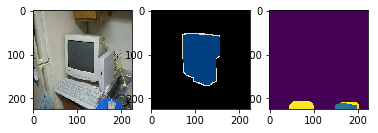

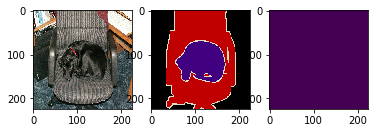

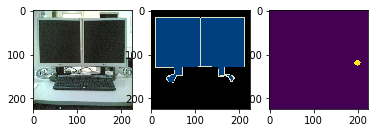

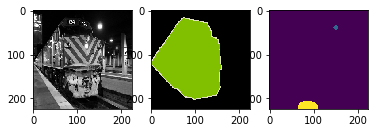

In [12]:
# load test data and 
#loader.reset()

batch = loader.get_batch(batch_size, 'test')

tensors = [vgg_fcn.pred_up]
feed_dict = {images: batch['images'], labels: batch['seg_labels']}

# forward network to obtain segmentation result
score  = sess.run(tensors, feed_dict=feed_dict)

for bi in range(batch_size):
    plot_result(batch['images'][bi], batch['seg_maps'][bi], score[0][bi], loader.get_palette())

## TEST the model
### Load the checkpoint

In [13]:
# reset the graph and session
tf.reset_default_graph()
sess.close()

with tf.variable_scope('inputs') as scope:
    images = tf.placeholder(dtype=tf.float32, 
                            shape=[batch_size, img_size, img_size, 3],
                            name='images')
    labels = tf.placeholder(dtype=tf.int64, 
                            shape=[batch_size, img_size, img_size], 
                            name='labels')

# build FCN
vgg_fcn = fcn_vgg.FCN()
with tf.name_scope("content_vgg"):
    vgg_fcn.build(images, net_type=net_type, train=False, num_classes=num_classes, debug=False)
    
# optimizer
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)

total_loss = get_loss(vgg_fcn.upscore, labels, num_classes)
train_op = tf.train.AdamOptimizer(initial_learning_rate).minimize(total_loss, global_step=global_step)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

# Automatically find the last checkpoint
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)
print('Last checkpoint path is %s' % (checkpoint_path))

# Create saver
saver = tf.train.Saver()
if checkpoint_path != '':
    saver.restore(sess, save_path=checkpoint_path)
    # You can use specific checkpoint_path
    '''
    saver.restore(sess, save_path='')
    '''
    print('Model is restored from %s' % checkpoint_path)

Last checkpoint path is fcn_16s_checkpoints/fcn_16s_vgg-10-518
INFO:tensorflow:Restoring parameters from fcn_16s_checkpoints/fcn_16s_vgg-10-518
Model is restored from fcn_16s_checkpoints/fcn_16s_vgg-10-518


### Compute the accuracy

In [14]:
# Predict segmentation labels for all test examples
# and compute confusion matrix
num_classes = loader_params['num_classes']
num_iterations = loader.get_num_test_examples() / batch_size
conf_counts = np.zeros((num_classes, num_classes))

loader.reset()
for ii in range(int(num_iterations)):
    # Load a batch data
    batch = loader.get_batch(batch_size, 'test')
    feed_dict = {images: batch['images'], labels: batch['seg_labels']}

    # Run the optimizer
    score = sess.run(vgg_fcn.pred_up, feed_dict=feed_dict)

    # Accumulate confusions
    for bi in range(batch_size):
        # Do not count boundary labels
        loc = np.where(batch['seg_labels'][bi] < 21, True, False)
        # row is gt labels and column is predicted labels
        sumim = batch['seg_labels'][bi] + score[bi] * num_classes
        hs, bin_edge = np.histogram(sumim[loc], np.arange(num_classes*num_classes+1), 
                                    (0, num_classes*num_classes+1))
        conf_counts = conf_counts + np.reshape(hs, (num_classes,num_classes))
    
    # Print the accuracy and loss of current batch data
    if ((ii+1) % print_frequency == 0) or ((ii+1) == num_iterations):
        print('TEST %d/%d Done' % (ii+1, num_iterations))

TEST 50/53 Done


In [15]:
# Compute accuracy for all classes and mean accuracy 
acc = np.zeros(num_classes)
for ic in range(num_classes):
    gt1 = np.sum(conf_counts[ic,:])
    res1 = np.sum(conf_counts[:,ic])
    gtlres = conf_counts[ic,ic]
    acc[ic] = 100.0 * gtlres / (gt1 + res1 - gtlres)
    if (ic > 0) and (ic < num_classes-1):
        print('%s IoU %.3f' % (class_names[ic-1], acc[ic]))
print('=============================================')
print('Mean IoU %.3f' % (np.mean(acc[1:num_classes])))

aeroplane IoU 0.000
bicycle IoU 0.000
bird IoU 0.000
boat IoU 0.000
bottle IoU 0.056
bus IoU 0.002
car IoU 0.000
cat IoU 0.000
chair IoU 0.000
cow IoU 0.000
diningtable IoU 0.050
dog IoU 0.000
horse IoU 0.000
motorbike IoU 0.000
person IoU 3.529
potted plant IoU 0.000
sheep IoU 0.000
sofa IoU 0.000
train IoU 0.000
tv/monitor IoU 0.000
Mean IoU 0.173
